# Principal Component Analysis (PCA)

The aim of this tutorial is to explain how PCA works, how to interpret the results and how you can use it in your research. Hopefully in a simplified way.

PCA is a dimensionality reduction method often used with large data frames. This means that if you have a data frame with large number of variables, PCA will be very helpful in **reducing the number of variables, while retaining most of the information**. Although this might lead to some data loss, the benefit of PCA is that you can trade some accuracy for much improved simplicity, which has its benefits as we will see. 

### What does PCA represent?

The main aim of PCA is to find components that hold as much information as possible. The first component holds most information, followed by the second and so on. You can think of the first component as camera that tries to find the best shot to show most of the data. The second component will be a second camera trying to find the second best shot (that is perpindicular to the first one), and so on.

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/main/pca_intro_1.png" width=1100 height=400 />

### But how do we actually compute it? ... Eigenvalues?! what is that?

To compute PCA that we need to find the axis that if you project the data onto, you would have the most variance possible (which means most information possible). Thankfully, there is a simple way to do it, which is by finding the eigenvalues and eigenvectors of your data.  Don't worry, I know I said 'simplified way' above, but I promise this will be simplified too. 

Simply put, eigenvectors describe the direction of each component. In other words, it is the best direction of a line that if you project the data onto, you capture most of the variance (and hence most of the information) while having the lowest possible distance from that line. 
In addition to the direction, we need a description of the value of each vector, or how important it is. This is where eigenvalues come into play: the higher the eigenvalue of each eigenvector, the more variance it holds, and the more information it contains.


<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/main/pca_intro_2.png" width=1300 height=450 />

If we plot the resulting PCs, we get the following:

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/main/pcs_plot.png" width=400 height=320 />

In this example above, the proportion of explained variance (proportion of information contained) for the two components are 96% and 4%. This means that we can safely discard of the second PC and describe our data using the first component only. But more on that later.

### What are its benefits and why do we need to reduce the number of variables?
- Get rid of useless variables: some variables do not add any meaningful information to your study. These might be particular EEG channels that do not pick your signal of interest or a set of genes not related to the character you are studying ... etc.
- Better visualization: Imagine you have 200,000 genes you want to plot to show their effect on particular trait.
- Avoiding redundency: Sometimes you measure the similar information using different questionnaires. You want one variable that represents each set of similar variables, without redundency and while retaining most information.
- Other: such as speeding up machine learning algorithms, better interpreting correlations between variables

You can check [this blog](https://glowingpython.blogspot.com/2011/07/pca-and-image-compression-with-numpy.html) to see how image information can be reduced using 40 components, producing an image very close to original with only 40 components

### Disadvantages:
- Lose information: You need to keep this in mind. If the reduction is not significant and your variables do not carry much shared information, you might need to consider using all variables without reduction
- Heavily affected by differences in variance (Thus, you will **always** need to normalize your data)

### Did someone say "PC loading"?
Finally, although PCs are purely mathematical entities, it would be very helpful if you can describe your components. This will make any analysis you do more interpretable and easier to understand. To do this, you need to know the contribution of each variable in the original data to each of the PCs. No need to worry, most software packages provide this as well. For example, if you have a data set about anxiety patients, and you have the following variables: age, anxiety level, harm avoidance level, worry level and quality of life, and you used PCA to get your components. Then you looked at the importance (or contribution or loading) of your components and found this:
- PC#1 → anxiety level, harm avoidance level, worry level
- PC#2 → age
- PC#3 → quality of life

Then, you can *roughly* call the first component "Anxiety", the second "Age" and the third "Quality of life".

Sometimes you do not find reasonable naming for your PCs. This is entirely normal, you can proceed with your analysis regardless.

Let's now see some examples ☺️







---
## Example 1: Psychological data
### 1. Load required libraries and functions

In [1]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
def plot_pca(pca):
    """
    plot the eigenvalues (ratio of explained variance) in a scree plot
    :param pca: fitted pca object
    :return: a scree plot of pca eigenvalues
    """
    eigenvalues = pca.explained_variance_ratio_
    n_comp = pca.n_components
    fig,ax = plt.subplots(figsize = (5,4))
    plt.plot(eigenvalues, color = 'steelblue')
    plt.scatter(np.arange(n_comp),eigenvalues, edgecolor = 'steelblue', color = 'white', linewidth = 2, zorder = 2)
    plt.title('Scree plot of PCA eigenvalues', size = 18)
    plt.xlabel('PCA Components',size = 13)
    plt.ylabel('Explained variance (Eigenvalues)',size = 13)
    plt.xticks(np.arange(n_comp),(np.arange(n_comp)+1))

def get_components(pca,or_cols,plot_result = False, text_threshold = 0.3,max_plot_feature = 20, max_plot_comp = 10):
    """
    retrieve the loadings for each PC. You can also plot the loadings.
    :param pca: fitted pca object
    :param or_cols: names of columns in the original data set (the one the PCA was fitted on)
    :param plot_result: whether to plot the loadings
    :param threshold: threshold for components to be considered. loadings with absolute values lower than
                      this threshold will be replaced with zeros
    :param max_plot_feature: maximum number of features to plot
    :param max_plot_comp: maximum number of PCs to plot
    :return: data frame representing the loadings of PCs on variables of the original dataset
    """
    n_comp = pca.n_components
    comp_or = pd.DataFrame(pca.components_.T, index=or_cols, columns=['PCA'+str(i+1) for i in range(n_comp)])

    # create a dataframe with reduced number of features for printing and plotting
    comp_th = np.round(comp_or, 4)
    if  max_plot_feature < comp_or.shape[0]:
        threshold = np.quantile(np.abs(comp_or), 1 - max_plot_feature / comp_or.shape[0], axis=0)
        comp_th[np.abs(comp_th)<threshold] = 0

    red_comp_count = np.min((max_plot_comp,n_comp, 10))
    comp_th = comp_th.loc[np.any(comp_th[['PCA' + str(i + 1) for i in range(red_comp_count)]]!=0, axis=1), :]

    comp_txt = comp_th.astype(str)
    comp_txt[np.abs(comp_or) < text_threshold] = 0
    comp_txt = pd.concat([comp_txt, pd.DataFrame([pca.explained_variance_ratio_], columns=comp_txt.columns, index=['Explained Var'])])
    #print(comp_txt)
    comp_or = pd.concat([comp_or, pd.DataFrame([pca.explained_variance_ratio_], columns=comp_or.columns, index=['Explained Var'])])
    if plot_result:
        plt_dat = comp_th

        x_range=(np.min(plt_dat)*1.05,np.max(plt_dat)*1.05)
        fig_width = np.min((18,2+3*red_comp_count))
        fig_height = np.min((8,1+1.5*red_comp_count))
        fig, axes = plt.subplots(ncols=red_comp_count, figsize=(fig_width, fig_height))
        colors = ['olivedrab', 'crimson','darkgoldenrod','steelblue','darkmagenta','grey','palevioletred','sienna','beige','coral']
        for i, col, label,ax in zip(np.arange(red_comp_count), colors, plt_dat.columns, axes.ravel()):
            ax.barh(plt_dat.index, plt_dat[label], color=col, edgecolor='black', linewidth=0.75)
            ax.set_xlabel(label+' loadings', size=13)
            ax.set_xlim(x_range[0],x_range[1])
            if i >0:
                ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        #plt.subplots_adjust(left=0.21, right=0.95, top=0.875, bottom=0.175, wspace=0.25)

    return comp_or



### 2. Load your dataset and take a general look
The data set is generated for this tutorial. However, it was not completely randomly generated. I looked at the published data from (K.Peter at al. 2017) and generated a dataset similar to it. This data set has the following variables: **id**, **pain score**, **BDI score**, **negative-view-of-self score**, **physical-function score** and **disability score**.
First, take a look at the data:


In [2]:
data_dir = 'https://github.com/abdulrahman1123/analysis_examples/raw/main/dep_pain.csv'
data = pd.read_csv(data_dir)
data.head()

,id,pain,bdi,neg_view_of_self,physical_fun,disability
0,1,9.5,26.0,9,9,45.795232
1,2,4.8,29.0,8,10,40.407772
2,3,9.2,15.0,2,10,46.557437
3,4,6.5,10.0,2,7,29.836585
4,5,7.9,13.0,6,4,40.840743


### 2.1 Normalize data
It is important to normalize your data before doing PCA. Otherwise you will have meaningless results ... kind of.

In [3]:
data_scaled = StandardScaler().fit_transform(data.iloc[:,1::])
data = pd.DataFrame(data_scaled,columns = data.columns[1::])

### 2.2 Create PCA for the entire dataset in order to determine the best number of components
For this, we will plot the eigenvalues (AKA explained variance or relative importance) of each PC, and determine the best number of variables. The function "plot_pca" used here can be found in **utils.py** file.

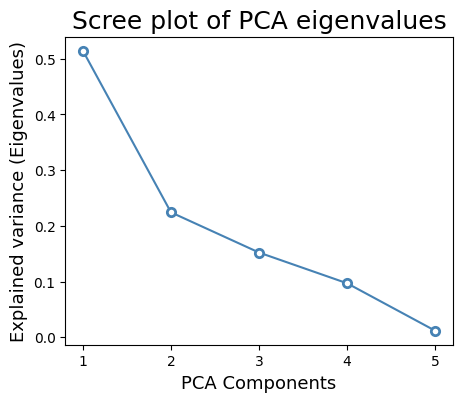

In [4]:
n_comp = data.shape[1]
pca_temp = PCA(n_components=n_comp)
data_pca_temp = pca_temp.fit_transform(data)
plot_pca(pca_temp)


#
Take a look at the figure above and decide where you can find an "elbow", where the values stop descending rapidly. Based on this, a good number of PCA components is 2. Let's proceed with that. The function "get_components" used here can be found in **utils.py** file.

,PCA1,PCA2
pain,0.210293,-0.682738
bdi,0.600261,0.174865
neg_view_of_self,0.503375,0.294027
physical_fun,0.538672,0.068452
disability,0.227836,-0.641992
Explained Var,0.514423,0.224394


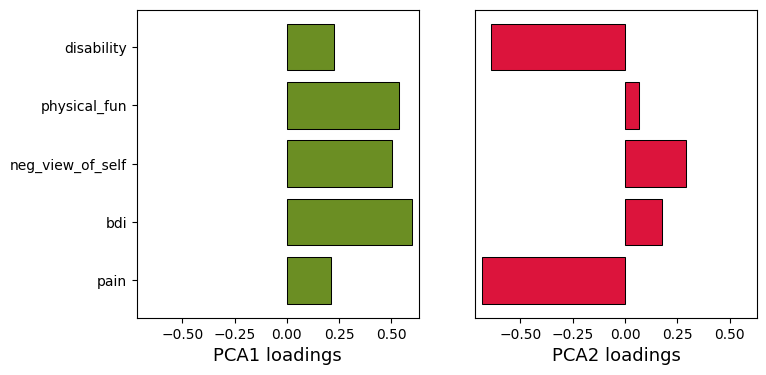

In [5]:
n_comp = 2

pca = PCA(n_components=n_comp)

data_pca = pca.fit_transform(data)

comp = get_components(pca,data.columns, True,0.35)

comp

From the figures above, we can say that we have two PCs. Looking at the "Explained Var" row, we see that these variables explain about 73% of the data, which is good percentage. This means that we can replace our 5 variables with only 2, and proceed with them.

Additionally, we can see that the first component has its highest contribution from BDI, physical function and negative view of self, which gives an idea of what this component represents, which we can roughly call "negative emotions". The second component has its highest loading from pain and disability. Thus, we can call it "pain & disability" component. It is not crucial to understand what each component means, but it would make your components more understandable to you and to you readers. However, do not worry about giving names for PCs as they sometimes do not represent anything meaningful to us.

Have a look at the final PCA data you have.

---
# Example 2: Genetics Data
The following data is published by: [Zhang Y et al. 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8762060/)

It represents RNA sequencing results for 30 patients with cancer and 30 control samples (matched normal tissue, I am assuming from the same patients). The data are of the type FPKM (Fragments Per kilobase Per Million reads), which basically represents the expression level per gene. The higher the number the higher the gene's expression.

Let's do the same steps as above:
- have a look at the data
- scale the data
- determine the number of components that you need


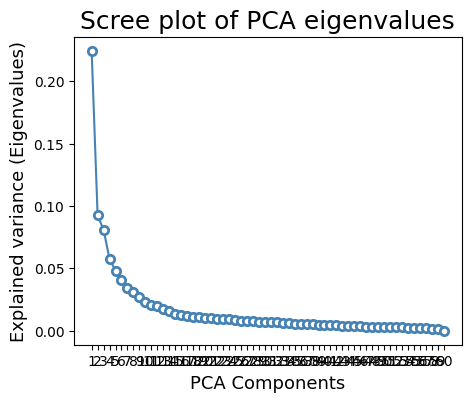

In [6]:
# read data
gendat = pd.read_csv('https://github.com/mmilano87/PCAPxDEG/raw/main/dataset/GSE183947_fpkm.csv')

# fix the data index and remove the first column
gendat.index = gendat['Unnamed: 0'].values
gendat = gendat.drop('Unnamed: 0',axis = 1)

# flip the data. Ultimately, we need each column to represent a gene, and each row to be one sample
gendat = gendat.T

# create a variable to represent the two subgroups in the data set. This will be helpful during plotting
subgroup = np.array(['Control' if item.startswith('CAP') else 'Cancer' for item in list(gendat.index)])

# MaxAbsScaler scales every feature based on its maximum absolute value
trans_gendat = MaxAbsScaler().fit_transform(gendat)
trans_gendat = pd.DataFrame(trans_gendat, index = gendat.index, columns=gendat.columns)

# determine best number of components
pca_temp = PCA(n_components=trans_gendat.shape[0])
pca_data = pca_temp.fit_transform(trans_gendat)

plot_pca(pca_temp)

#
### Perform PCA using 10 components (you can change it if you want)
Have a look at the most important 10 genes for each component.

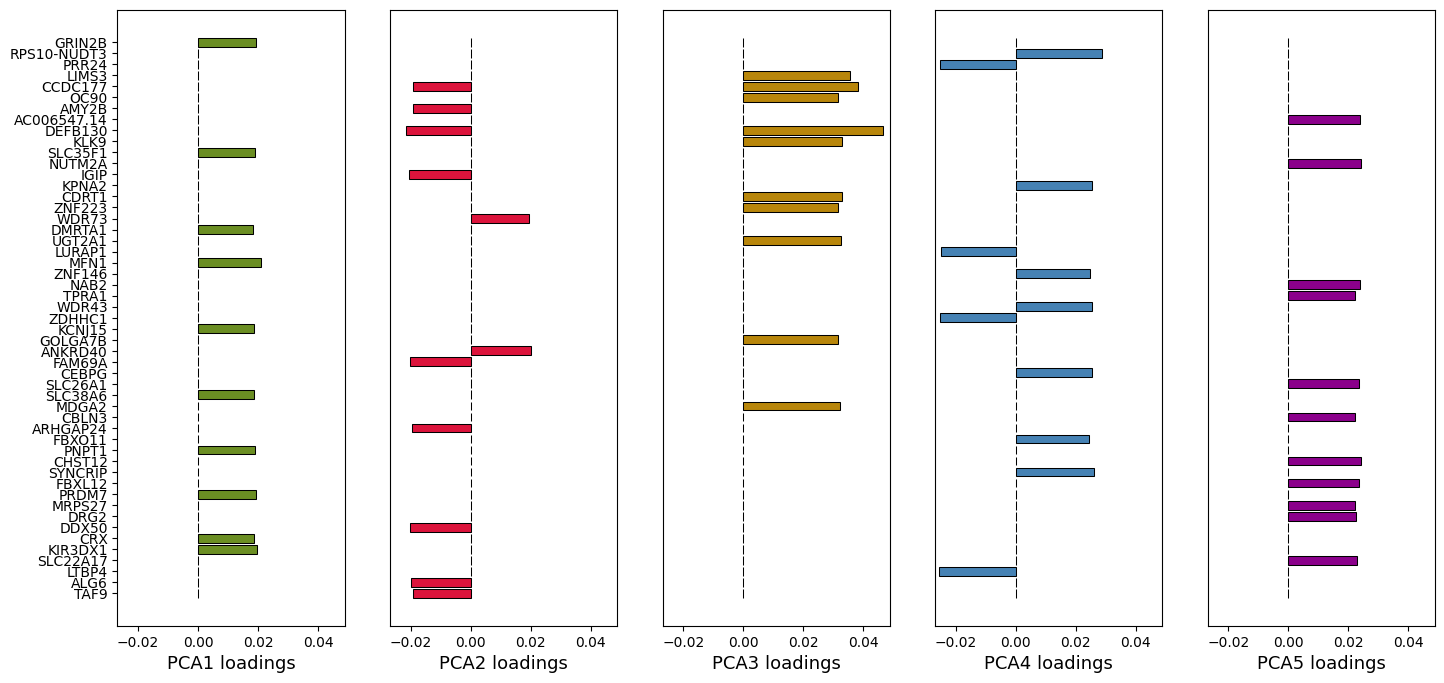

In [7]:
n_comp = 10

pca = PCA(n_components=n_comp)
pca_data = pca.fit_transform(trans_gendat)
pca_data = pd.DataFrame(pca_data, columns = ['PCA'+str(i+1) for i in range(n_comp)])
pca_data.index =gendat.index

pca_comp = get_components(pca,or_cols=trans_gendat.columns, plot_result=True,text_threshold=0.005, max_plot_feature=10, max_plot_comp=5)



### Take a look at the resulting dataframe

In [8]:
pca_data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
CA.102548,10.545882,22.839162,-3.055666,-9.591640,0.494727,-10.168811,-1.715138,0.522849,-0.055455,-1.029230
CA.104338,7.106748,19.649573,-2.978488,-8.744820,0.761682,-8.087516,-1.591028,0.903118,-1.844114,-3.843172
CA.105094,18.978858,31.195735,0.932433,-5.091639,-4.548254,-16.152816,-5.399189,-4.075258,1.208106,2.824578
CA.109745,-3.533489,5.100169,-5.695281,-2.495177,0.728790,-1.025101,-2.631676,-0.016386,-0.336679,-0.126930
CA.1906415,-3.308834,4.709394,-2.018390,-1.883190,0.542681,-1.220682,2.455399,1.631463,-2.878353,-3.752119


### Let's check which of these components is relevant to our Cancer samples
For this, we need to plot the most important PCs and see which of them are able to split the samples into Cancer vs Control. The first components usually have higher chance of doing this, as they carry more information than the rest of the components.

''

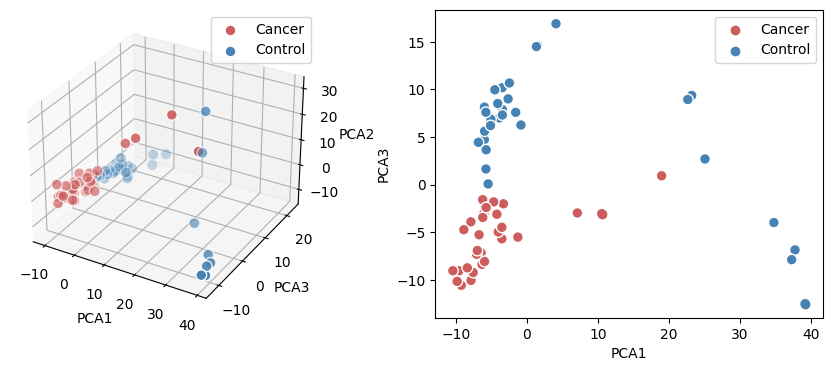

In [9]:
colors = np.where(subgroup=='Control','steelblue','indianred')

fig = plt.figure(figsize=(11,4))
ax = fig.add_subplot(121,projection = '3d')

ax.scatter(pca_data['PCA1'],pca_data['PCA3'],pca_data['PCA2'], c=colors, s = 60, edgecolors='white', linewidth = 1)
ax.set_xlabel('PCA1');ax.set_ylabel('PCA3');ax.set_zlabel('PCA2')
for group,color in zip(np.unique(subgroup),['indianred','steelblue']):
    ax.scatter(pca_data.loc[subgroup==group,'PCA1'].values[0],pca_data.loc[subgroup==group,'PCA2'].values[0],
               pca_data.loc[subgroup==group,'PCA3'].values[0],s=60,edgecolors='white',c=color, label = group)
plt.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(pca_data['PCA1'],pca_data['PCA3'],c = colors, edgecolor = 'white',s = 60)
ax2.set_xlabel('PCA1');ax2.set_ylabel('PCA3')
for group,color in zip(np.unique(subgroup),['indianred','steelblue']):
    ax2.scatter(pca_data.loc[subgroup==group,'PCA1'].values[0],pca_data.loc[subgroup==group,'PCA3'].values[0],
                c=color, label = group)
plt.legend()

"""ax3 = fig.add_subplot(133)
ax3.scatter(pca_data['PCA1'],pca_data['PCA3'],c = colors, edgecolor = 'white',s = 60)
ax3.set_xlabel('PCA1');ax3.set_ylabel('PCA3')
for group,color in zip(np.unique(subgroup),['indianred','steelblue']):
    ax2.scatter(pca_data.loc[subgroup==group,'PCA1'].values[0],pca_data.loc[subgroup==group,'PCA3'].values[0],
                c=color, label = group)
plt.legend()
plt.subplots_adjust(wspace=0.5)"""
''


PC #3 seems to get the job done. So, in a sense, we can say that the information carried within PC #3 are relevant to differentiating cancer from control. This means that the RNA sequences you are testing carry information about cancer ... so, good job, this confirms that your choice of genetics are relevant to your problem, which is always good. But, that is not enough ... so, what else can you do with this?

Maybe you can:
- have a look at the genes that have the highest loading on PC3, consider them cancer-related and do further analysis on them
- confirm other findings you already have using other analysis methods
- What else?


----
# Extra Content
### Excercise: 
Extract the 1% most-expressed (99th percentile) and lowest-expressed (1st percentile) genes.

Sample code is provided below

In [10]:
pca_3_dat = pca_comp['PCA3'].iloc[0:-1]
# To extract the values above the 99th percentile, modify this line:
# th_99 = np.percentile(pca_3_dat,<chosen_percentile>)

# For the 1st percentile, modify this line
#th_01 = np.percentile(pca_3_dat,<chosen_percentile>)

highest_expressed = pca_3_dat.loc[pca_3_dat>th_99].index
lowest_expressed = pca_3_dat.loc[pca_3_dat<th_01].index

print('Genes of highest expression: ', highest_expressed)
print('Genes of lowest expression: ', lowest_expressed)

NameError: name 'th_99' is not defined

### What more can you do?

While this might not be the best way to find the most relevant genes. It can be a start point for your anlaysis, or a confirmation of other analyses. For example, getting back to the original paper of Zhang Y et al. 2021 ([found here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8762060/)), we find that the authors identified the differentially expressed genes (DEG), which takes logFC and p-value into account. You can open [this link](https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=8762060_fgene-12-723477-g001.jpg) to see their results.

In this analysis, they grouped the genes into two based on their expression levels and found that they group into two groups. Each group corresponds nicely with the type of sample (cancerous vs control). We can prove this by looking at the PCA3 value of the DEGs as follows:

(-0.75, 52.0)

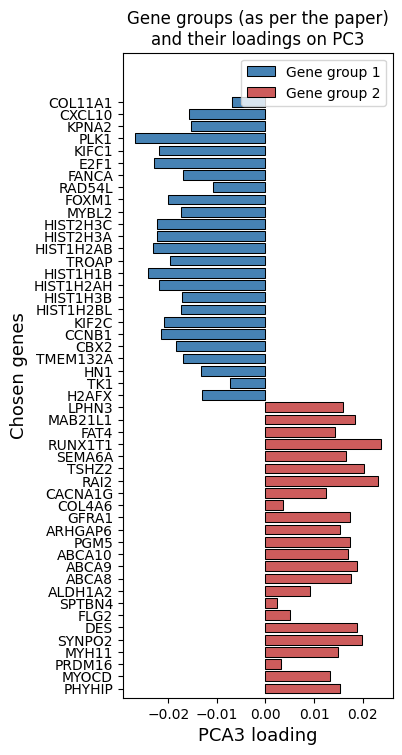

In [11]:
gene_group_1 = ['COL11A1','CXCL10','KPNA2','PLK1','KIFC1','E2F1','FANCA','RAD54L','FOXM1','MYBL2','HIST2H3C','HIST2H3A',
               'HIST1H2AB','TROAP','HIST1H1B','HIST1H2AH','HIST1H3B','HIST1H2BL','KIF2C','CCNB1','CBX2','TMEM132A','HN1','TK1','H2AFX']
gene_group_2 = ['LPHN3','MAB21L1','FAT4','RUNX1T1','SEMA6A','TSHZ2','RAI2','CACNA1G','COL4A6','GFRA1','ARHGAP6',
               'PGM5', 'ABCA10','ABCA9','ABCA8','ALDH1A2','SPTBN4','FLG2','DES','SYNPO2','MYH11','PRDM16','MYOCD','PHYHIP']


gene_group_1.reverse()
gene_group_2.reverse()
inc_genes = gene_group_2+gene_group_1


plt_comp = pca_comp.loc[inc_genes,'PCA3']
colors = ['indianred']*len(gene_group_2)+['steelblue']*len(gene_group_1)
fig, ax = plt.subplots(figsize=(4, 7.5))
ax.barh(plt_comp.index, plt_comp, color=colors, edgecolor='black', linewidth=0.75)
ax.barh(plt_comp.index[-1], plt_comp.iloc[-1], color=colors[-1], edgecolor='black', linewidth=0.75, label = 'Gene group 1')
ax.barh(plt_comp.index[0], plt_comp.iloc[0], color=colors[0], edgecolor='black', linewidth=0.75, label = 'Gene group 2')
ax.set_title('Gene groups (as per the paper)\nand their loadings on PC3')
ax.set_xlabel('PCA3 loading', size=13)
ax.set_ylabel('Chosen genes', size=13)
plt.legend()
plt.subplots_adjust(left=0.3, right=0.975, top=0.93, bottom=0.07)
ax.set_ylim(-0.75,len(inc_genes)+3)

---
# References and further reading

[Tutorial from Builtin website](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

[Machine learnign mastery website](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/)

[Prof Gregory Valiant notes](https://web.stanford.edu/class/cs168/l/l7.pdf)

[Paper by Zhang Y et al. 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8762060/)

[Glowing python blog](https://glowingpython.blogspot.com/2011/07/pca-and-image-compression-with-numpy.html)

[Saksham Gakhar blog](https://web.stanford.edu/~sakshamg/portfolio/PCA_genomes/)